# **BLP**:: **B**inary **L**ega**L** **P**roduct c**L**assifier

#### *Versão 1.0: Primeiros testes com Redes Neurais RNN (Recurrent Neural Network) utilizando uma base de filmes*


## Objetivo
Construir uma rede neural utilizando LSTM (Long Short-Term Memory) para classificação de textos.
Os textos são as descrições de produtos. O objetivo final é classificá-los entre produtos legais ou ilegais para comercialização.

# Setup inicial

Importação das bibliotecas do Python e TensorFlow, assim como da `matlplotlib`. Também adiciona uma função para ajudar no preenchimento dos gráficos de análise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Épocas")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### **Setup dos inputs**

Os textos importados pertencem à uma base de filmes. Estamos usando a TFDS, uma coleção de *datasets* do próprio Tensorflow, para fins de facilitar o desenvolvimento para estudos.

Os *inputs* para treino são separados entre *reviews* positivas ou negativas, para uma classificação binária.
Utilizaremos duas bases: uma para treino (`train`) e outra para que a rede classifique manualmente (`test`).

O dataset está dividido em: `text` para o *review* e `label` para a classificação (valores 0 ou 1).

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

# for review, label in train_dataset.take(1):
#   print('text: ', review.numpy())
#   print('label: ', label.numpy())

AttributeError: 'tuple' object has no attribute 'numpy'

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Primeira camada: processamento dos textos

[`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization), do Keras, será usado.

*Nota: ver quais outras configurações do `TextVectorization` podem ser usadas.*


O resultado final será uma lista de 20 tokens, contendo palavras-chave retiradas das *reviews*. Isso será o vocabulário extraído.

In [5]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

O próximo passo é configurar o processo de treinamento, compilando o modelo do Keras que iniciamos na sessão anterior.

In [7]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Treinamento do modelo

In [8]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 101ms/step - loss: 0.6821 - accuracy: 0.5154 - val_loss: 0.4433 - val_accuracy: 0.7953
Epoch 2/10
391/391 [==============================] - 37s 95ms/step - loss: 0.3981 - accuracy: 0.8180 - val_loss: 0.3498 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 37s 96ms/step - loss: 0.3349 - accuracy: 0.8532 - val_loss: 0.3405 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 38s 96ms/step - loss: 0.3176 - accuracy: 0.8614 - val_loss: 0.3285 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 39s 100ms/step - loss: 0.3108 - accuracy: 0.8655 - val_loss: 0.3271 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 39s 100ms/step - loss: 0.3073 - accuracy: 0.8676 - val_loss: 0.3245 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 0.3016 - accuracy: 0.8700 - val_loss: 0.3325 - val_accur

#### **Analisando dados (perda e precisão/acurácia)**

Imprimindo alguns gráficos para analisar a acurácia e a perda das análises.

Lembrando: quanto menor a perda, melhor o modelo. É uma somatória de erros calculada analisando os resultados entre os inputs de treino e de teste.

Para melhorar esse quesito, pode ser aplicado *backpropagation*, rever a base de dados ou rodar o treinamento mais vezes.

No caso de *overfitting*, a perda será naturalmente maior do que deveria. Precisaria rever o *dataset*, aplicar regularizações (talvez?) ou parar de rodar o treinamento tantas vezes para tentar diminuir as perdas.

A precisão do modelo é determinada depois que os parâmetros do modelo são aprendidos e corrigidos pela rede, não tendo mais aprendizados ocorrendo. Então as amostras de teste são retornadas ao modelo, e o número de erros (que somados dão a perda) que o modelo teve é registrado, comparando com os valores que deveriam ter sido retornados (o input de treino tem os valores corretos para comparação. Com isso, a porcentagem de classificação feita corretamente é calculada.

A precisão é uma porcentagem, mas não a perda.

E.g.: Se um dataset possui 1k de dados e a perda é de 48, a precisão do modelo é de 95,2%.

(0.0, 0.6498652055859566)

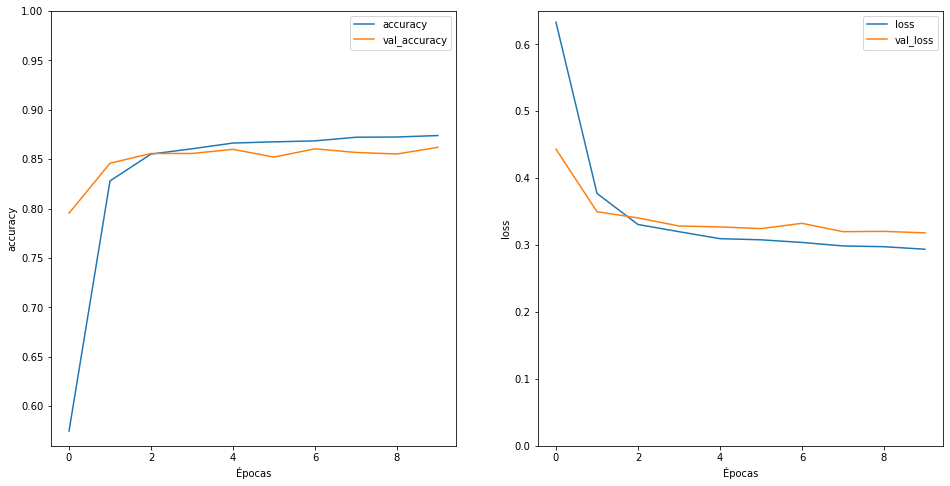

In [9]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Teste com uma avaliação do LotR

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 37ms/step - loss: 0.3149 - accuracy: 0.8639
Test Loss: 0.31486085057258606
Test Accuracy: 0.8639199733734131


In [11]:
sample_text = ('LotR and trilogy in general, is a cinematic (and literary) masterpiece, '
                'and simply refuses to get old. I love this movie so much it is become '
                'a tradition to watch the Lord of the Rings series at least once a year!')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[1.1244326]]


In [12]:
sample_text = ('I can not believe that this movie received all the awards that it did. '
                'It was long, slow-moving, predictable, and the acting was terrible. '
                'I can not believe that they cut out over an hours worth of video to '
                'get it down to this length')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[-2.5579739]]


# Treinando com mais uma camada de LSTM

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 91s 180ms/step - loss: 0.6867 - accuracy: 0.5101 - val_loss: 0.4699 - val_accuracy: 0.7755
Epoch 2/10
391/391 [==============================] - 65s 166ms/step - loss: 0.4361 - accuracy: 0.8028 - val_loss: 0.3831 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 65s 167ms/step - loss: 0.3685 - accuracy: 0.8467 - val_loss: 0.3616 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - 64s 165ms/step - loss: 0.3349 - accuracy: 0.8624 - val_loss: 0.3958 - val_accuracy: 0.8495
Epoch 5/10
391/391 [==============================] - 64s 164ms/step - loss: 0.3403 - accuracy: 0.8583 - val_loss: 0.3349 - val_accuracy: 0.8510
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3223 - accuracy: 0.8619 - val_loss: 0.3418 - val_accuracy: 0.8380
Epoch 7/10
391/391 [==============================] - 65s 165ms/step - loss: 0.3097 - accuracy: 0.8682 - val_loss: 0.3248 - val_ac

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.6970426]]


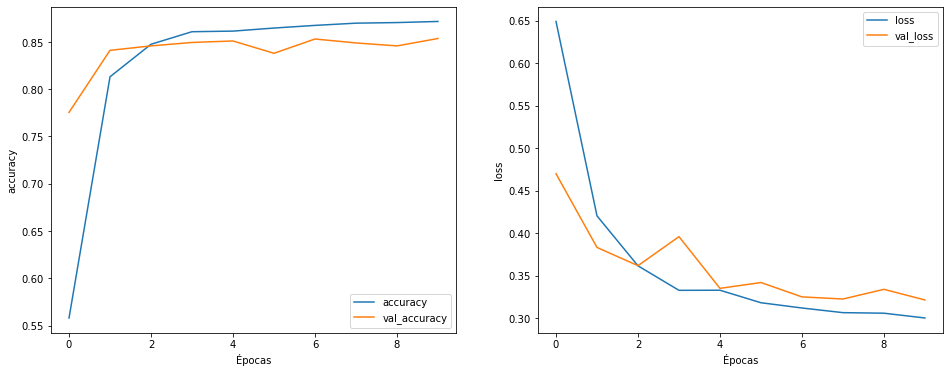

In [17]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [18]:
sample_text = ('LotR and trilogy in general, is a cinematic (and literary) masterpiece, '
                'and simply refuses to get old. I love this movie so much it is become '
                'a tradition to watch the Lord of the Rings series at least once a year!')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[0.9063699]]


In [19]:
sample_text = ('I can not believe that this movie received all the awards that it did. '
                'It was long, slow-moving, predictable, and the acting was terrible. '
                'I can not believe that they cut out over an hours worth of video to '
                'get it down to this length')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[-3.3470213]]


In [20]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     print("Name:", gpu.name, "  Type:", gpu.device_type)